##Necessidade 1: Análise exploratória dos dados:

**Considere** fazer o pré-processamento de texto, remover stopwords, gerar estatísticas para os diferentes idiomas, gerar uma nuvem de palavras (wordcloud) para o idioma português, gráficos de distribuição de label, etc.

**Requisitos obrigatórios:** estatísticas descritivas e nuvem de palavras de cada idioma e de todos juntos, ao menos 3 gráficos informativos (p. ex. contagem de palavras, histograma de labels).

-----

## Necessidade 3: Predição binária de label:

**Considere** separar só textos em português, fazer o pré-processamento de texto, remover stopwords, transformar a coluna label (numérica) em categórica (2 categorias, maior que 2.5 e menor ou igual a 2.5), dividir a base em treino e teste e treinar um modelo de classificação de Machine Learning para predizer label.

**Requisitos obrigatórios:** acurácia na partição de testes.

-----

## Pré processamento do texto

> Essa tarefa é comum de ambas as necessidades N1 e N3 (aliás, de todas elas) e vai ser feita antes de iniciar a solução em si.

para o pré processamento, eu criarei uma coluna que faz a tradução de todos os textos, para trabalhar em um único idioma.

Além de fazer com que a remoção de stopwords possa ser usada independente do idioma, isso faz com que eu tenha mais amostras em português (e, em Machine learning, no geral, quanto mais melhor).

In [37]:
#instalar e importar
if False:
  !pip install googletrans==4.0.0-rc1
  !pip install nltk

  # Baixar a lista de stopwords em português
  import nltk
  nltk.download('stopwords')
  
from tqdm.auto import tqdm
from nltk.corpus import stopwords
from googletrans import Translator
import pandas as pd
import numpy as np
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix


tqdm.pandas()

In [5]:
df = pd.read_csv('train.csv')

df = df.sample(800)

print(df.info()) #type sniffer
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 5372 to 3961
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   text      800 non-null    object 
 1   label     800 non-null    float64
 2   language  800 non-null    object 
dtypes: float64(1), object(2)
memory usage: 25.0+ KB
None


,text,label,language
3493,"sou muito surtadinha, não dá",3.0,Portuguese
1952,@user Cosas como esa no pasan en mi sala 🤦🏻‍♂️,2.8,Spanish
8848,@user 没意思吧 拿视频 希望你能私信我,3.2,Chinese
8915,@user 電影（老ㄙ這個人連出兩題,2.0,Chinese
8876,小骚妇，水超级多，全程16分钟喷了4次水，16分钟免费高清下载地址：https://t.co...,3.0,Chinese


In [6]:
df.language.unique()

array(['Italian', 'French', 'English', 'Chinese', 'Portuguese', 'Spanish'],
      dtype=object)

In [7]:
# Em seguida, crie uma função que recebe o texto e o idioma original e
# retorna o texto traduzido para português. Por fim, aplique essa função
# na coluna 'text' do seu dataframe. 

# Dicionário de mapeamento dos nomes dos idiomas para os códigos ISO 639-1
language_mapping = {
    'English'   : 'en',
    'Spanish'   : 'es',
    'Portuguese': 'pt',
    'Italian'   : 'it',
    'French'    : 'fr',
    'Chinese'   : 'zh-cn'
}

tradutor = Translator()

def traduzir_para_portugues(texto, idioma_original):
    # Mapear o idioma_original para o código ISO 639-1
    idioma_codigo = language_mapping[idioma_original]
    
    # print(texto, idioma_original, idioma_codigo)
    
    # Traduzir o texto para português
    if texto == None:
      return ""
    
    if idioma_codigo == 'pt':
      return texto

    try:
      texto_traduzido = tradutor.translate(texto, src=idioma_codigo, dest='pt')
    except:
      return ""

    return texto_traduzido.text

# Aplicando a função de tradução na coluna 'text'
df['text_pt'] = df.progress_apply(lambda row: traduzir_para_portugues(row['text'], row['language']), axis=1)


  0%|          | 0/800 [00:00<?, ?it/s]

In [24]:
stop_words_pt = stopwords.words('portuguese') + ['user', 'User', '@user', '@User', 
                                                 'user,', 'User,', '@user,', '@User,']

# Função para remover stopwords
def remover_stopwords(texto):
    texto_alfanumerico = re.sub(r'\W+', ' ', texto)
    
    return ' '.join([word for word in texto_alfanumerico.split() if word not in stop_words_pt])

# Remover stopwords da coluna 'text_pt'
df['text_pt_sem_stopwords'] = df['text_pt'].apply(remover_stopwords)

df.sample(5)

,text,label,language,text_pt,text_pt_sem_stopwords
67,@user I vote for BTS 'Dynamite' by Son Sung De...,1.4,English,@User I Voto no BTS 'Dynamite' por Son Sung De...,I Voto BTS Dynamite Son Sung Deuk FaveChoreogr...
2282,@user Súper sarcástico y la gente ni lo coge,2.4,Spanish,@User Super Sarcastic e pessoas ou pegue,Super Sarcastic pessoas pegue
1999,@user @user Yo también vi algo así. Tremendo.,1.6,Spanish,@User @User eu também vi algo assim.Tremendo.,vi algo assim Tremendo
6533,Des gros sacs Snippes pour y foutre des baguet...,1.8,French,Big snippes sacolas para baguetes estripadas n...,Big snippes sacolas baguetes estripadas nele M...
2916,Que carajo la gente que comparte tus historias...,1.6,Spanish,Que inferno pessoas que compartilham suas hist...,Que inferno pessoas compartilham histórias pub...


## Necessidade 1 (parcialmente resolvida)

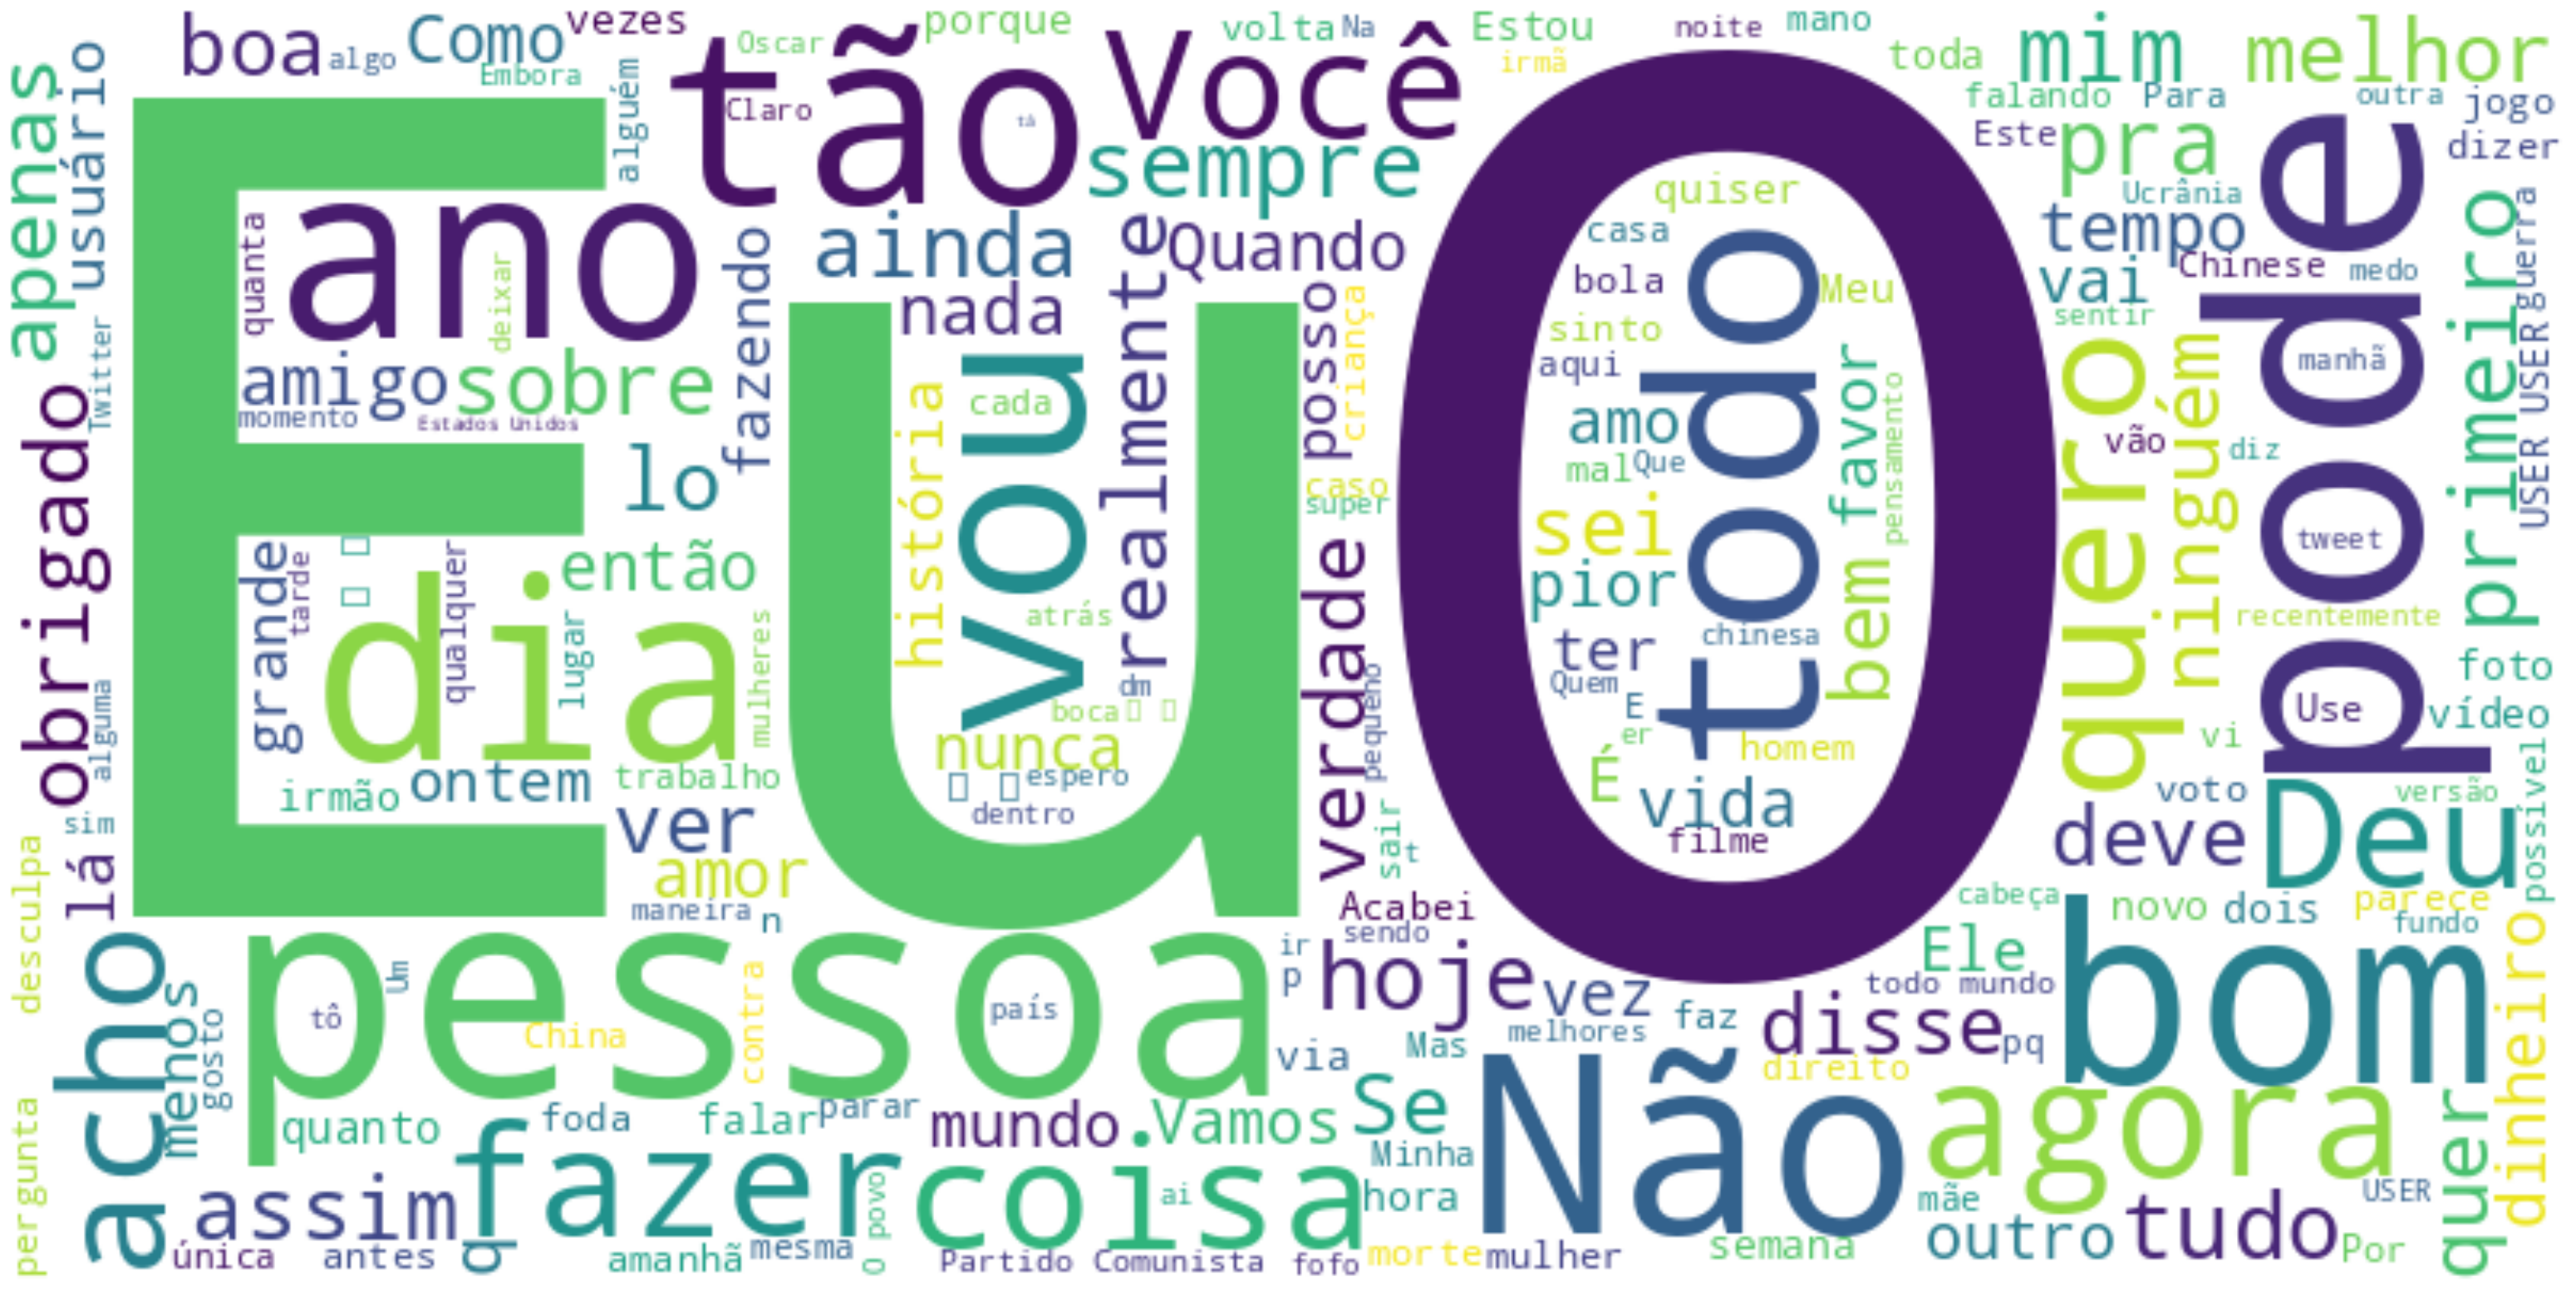

In [25]:
# Concatenar todo o texto da coluna 'text_pt_sem_stopwords'
texto = " ".join(text for text in df['text_pt_sem_stopwords'])

# Gerar a nuvem de palavras
wordcloud = WordCloud(background_color="white", width=800, height=400).generate(texto)

# Exibir a nuvem de palavras gerada
plt.figure(figsize=(40, 20))
plt.axis("off")
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

## Necessidade 2

In [33]:
def converter_em_classe_binaria(valor):
    if valor >= 1 and valor <= 3:
        return 0
    elif valor > 3:
        return 1
    else:
        return None

df['label_binaria'] = df['label'].apply(converter_em_classe_binaria)

In [49]:
df.sample(3)

,text,label,language,text_pt,text_pt_sem_stopwords,label_binaria
6550,Ma meuf elle aimait pas les disquettes de @use...,4.20,French,Minha garota ela não gostou @User Disklate Eu ...,Minha garota gostou Disklate Eu quero ninguém ...,1
1769,FUA* Wtf como día,1.75,Spanish,Fua* wtf como dia,Fua wtf dia,0
4273,vou ouvir dont call me angel até gostar,1.60,Portuguese,vou ouvir dont call me angel até gostar,vou ouvir dont call angel gostar,0


In [38]:
X = df['text_pt_sem_stopwords']
y = df['label_binaria']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [39]:
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)

In [40]:
X_test_vec = vectorizer.transform(X_test)


In [41]:
clf = MultinomialNB()
clf.fit(X_train_vec, y_train)


MultinomialNB()

In [42]:
y_pred = clf.predict(X_test_vec)

accuracy = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)

print("Acurácia:", accuracy)
print("Matriz de Confusão:\n", conf_mat)

Acurácia: 0.835
Matriz de Confusão:
 [[167   3]
 [ 30   0]]


In [54]:
frase = "os carros são como as lanchas. Circuito de consagração social"
frase = "Minha garota gostou Disklate Eu quero ninguém"
frase = "frase_vec = vectorizer.transform([frase])"

frase = remover_stopwords(frase)

frase_vec = vectorizer.transform([frase])
predicao = clf.predict(frase_vec)
probas = clf.predict_proba(frase_vec)
print("Previsão:", predicao[0])
print("Probabilidades:", probas)


Previsão: 0
Probabilidades: [[0.86 0.14]]
